In [10]:
import pandas as pd

df = pd.read_csv("../data/processed/segmento1_csv/cooperativas_segmento1_completo_final.csv")
print(df.shape)
df.head(10)


(42, 47)


,RUC,INSTITUCIÓN,SEGMENTO,CALIFICADORA,CALIFICACIÓN,RANKING,( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS,ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS,ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS,ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO,...,RENDIMIENTO DE LA CARTERA DE CREDITO EDUCATIVO POR VENCER,CARTERAS DE CRÉDITOS REFINANCIADAS,CARTERAS DE CRÉDITOS REESTRUCTURADAS,CARTERA POR VENCER TOTAL,FONDOS DISPONIBLES / TOTAL DEPOSITOS A CORTO PLAZO,CARTERA IMPRODUCTIVA DESCUBIERTA / (PATRIMONIO + RESULTADOS),CARTERA IMPRODUCTIVA / PATRIMONIO (DIC),FK = (PATRIMONIO + RESULTADOS - INGRESOS EXTRAORDINARIOS) / ACTIVOS TOTALES,FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTALES),INDICE DE CAPITALIZACION NETO: FK / FI
0,590052000001,PEQUEÑA EMPRESA DE COTOPAXI LIMITADA,SEGMENTO 1,PACIFIC CREDIT RATING S.A.,AAA,1,-233.715,0.025,0.975,1.282,...,0.0,0.166,0.190,0.161,0.374,0.000,0.311,0.202,1.025,0.197
1,1790567699001,29 DE OCTUBRE LTDA,SEGMENTO 1,RIESGOS / CLASS INTERNATIONAL RATING,AA,2,2.184,0.073,0.927,1.040,...,0.0,0.146,0.137,0.151,0.278,0.157,0.857,0.084,1.073,0.079
2,1790325083001,ANDALUCIA LIMITADA,SEGMENTO 1,SUMMA RATINGS S.A. UNION RATINGS S.A. / PACIFIC,AA,2,0.600,0.193,0.807,0.913,...,0.0,0.154,0.170,0.147,0.359,0.000,0.450,0.094,1.193,0.079
3,1790501469001,ALIANZA DEL VALLE LIMITADA,SEGMENTO 1,RIESGOS / SUMMA RATINGS S.A.,AA,2,1.648,0.095,0.905,1.046,...,0.0,0.130,0.133,0.155,0.349,0.000,0.482,0.101,1.095,0.092
4,1790979016001,DE LOS\nSERVIDORES PUBLICOS DEL MINISTERIO DE\...,SEGMENTO 1,UNION RATINGS S.A.,AA,2,11.282,0.042,0.958,1.317,...,0.0,0.116,0.112,0.118,0.345,0.000,0.043,0.244,1.042,0.234
5,690045389001,RIOBAMBA LTDA,SEGMENTO 1,RIESGOS S.A. MICRORIESG,AA,2,12.343,0.045,0.955,1.180,...,0.0,0.156,0.191,0.140,0.434,0.000,0.161,0.161,1.045,0.154
6,1690012606001,PEQUEÑA EMPRESA DE PASTAZA LIMITADA,SEGMENTO 1,CLASS INTERNATIONAL RATING,AA,2,7.345,0.069,0.931,1.165,...,0.0,0.189,0.238,0.160,0.344,0.000,0.206,0.163,1.069,0.152
7,1090033456001,ATUNTAQUI LIMITADA,SEGMENTO 1,CREDIT RATING S.A. MICROFINANZA CALIFICADORA DE,AA,2,2.400,0.061,0.939,1.037,...,0.0,0.152,0.150,0.136,0.365,0.000,0.625,0.069,1.061,0.065
8,190155722001,JARDIN AZUAYO LIMITADA,SEGMENTO 1,WATCH RATINGS S.A.,AA,2,-22.964,0.039,0.961,1.101,...,0.0,0.159,0.304,0.148,0.492,0.000,0.364,0.103,1.039,0.099
9,190115798001,JUVENTUD ECUATORIANA PROGRESISTA\nLIMITADA,SEGMENTO 1,RATINGS S.A.,AA,2,2.254,0.094,0.906,1.039,...,0.0,0.179,0.171,0.144,0.323,0.000,0.423,0.098,1.094,0.089


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 47 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   RUC                                                                          42 non-null     int64  
 1   INSTITUCIÓN                                                                  42 non-null     object 
 2   SEGMENTO                                                                     42 non-null     object 
 3   CALIFICADORA                                                                 42 non-null     object 
 4   CALIFICACIÓN                                                                 42 non-null     object 
 5   RANKING                                                                      42 non-null     int64  
 6   ( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVI

In [12]:
# Porcentaje de nulos por columna
na_pct = df.isna().mean().sort_values(ascending=False) * 100
na_pct[na_pct > 0]

Series([], dtype: float64)

In [13]:
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols].describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
RUC,42.0,1.178460e+12,6.303600e+11,1.900218e+11,5.904668e+11,1.290039e+12,1.790551e+12,1.891710e+12
RANKING,42.0,3.000000e+00,1.036000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,6.000000e+00
( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS,42.0,-2.726000e+00,3.700200e+01,-2.337150e+02,1.330000e+00,2.102000e+00,4.980000e+00,2.165800e+01
ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS,42.0,9.900000e-02,6.100000e-02,1.500000e-02,6.200000e-02,8.500000e-02,1.070000e-01,2.570000e-01
ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS,42.0,9.010000e-01,6.100000e-02,7.430000e-01,8.930000e-01,9.150000e-01,9.380000e-01,9.850000e-01
ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO,42.0,1.066000e+00,9.900000e-02,8.630000e-01,1.018000e+00,1.058000e+00,1.127000e+00,1.317000e+00
MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO,42.0,7.000000e-02,1.630000e-01,0.000000e+00,0.000000e+00,3.000000e-03,6.700000e-02,8.330000e-01
MOROSIDAD DE LA CARTERA DE CONSUMO,42.0,6.000000e-02,2.500000e-02,1.300000e-02,4.000000e-02,5.400000e-02,7.200000e-02,1.290000e-01
MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO,42.0,3.700000e-02,3.800000e-02,0.000000e+00,1.100000e-02,2.700000e-02,5.300000e-02,1.590000e-01
MOROSIDAD DE LA CARTERA DE MICROCREDITO,42.0,1.240000e-01,6.500000e-02,0.000000e+00,8.300000e-02,1.240000e-01,1.440000e-01,3.140000e-01


In [17]:
cat_cols = df.select_dtypes(exclude=np.number).columns

for c in cat_cols:
    print(f"\n==== {c} ====")
    vc = df[c].value_counts(dropna=False).to_frame(name="freq")
    vc["pct"] = 100 * vc["freq"] / vc["freq"].sum()
    vc["pct"] = vc["pct"].round(2)
    display(vc) # ¡Aquí quitamos el .head(10)!


==== INSTITUCIÓN ====


,freq,pct
INSTITUCIÓN,,
PEQUEÑA EMPRESA DE COTOPAXI LIMITADA,1,2.38
CALCETA LTDA,1,2.38
23 DE JULIO LIMITADA,1,2.38
AMBATO LTDA,1,2.38
VICENTINA MANUEL ESTEBAN GODOY ORTEGA\nLIMITADA,1,2.38
PADRE\nJULIÁN LORENTE LTDA,1,2.38
POLICÍA\nNACIONAL LIMITADA,1,2.38
KULLKI\nWASI LTDA,1,2.38
CHONE LTDA,1,2.38



==== SEGMENTO ====


,freq,pct
SEGMENTO,,
SEGMENTO 1,42,100.0



==== CALIFICADORA ====


,freq,pct
CALIFICADORA,,
PACIFIC CREDIT RATING S.A.,5,11.90
CLASS INTERNATIONAL RATING,5,11.90
RIESGOS S.A.,3,7.14
SUMMA RATINGS S.A. MICROFINANZA CALIFICADORA DE,2,4.76
RATINGS S.A.,2,4.76
MICROFINANZA CALIFICADORA DE RIESGOS S.A.,2,4.76
RATINGS CALIFICADORA DE RIESGOS S.A.,1,2.38
UNION RATINGS S.A. GLOBAL RATINGS CALIFICADORA DE,1,2.38
RIESGOS S.A. PACIFIC CREDIT RATING S.A. / BANK,1,2.38



==== CALIFICACIÓN ====


,freq,pct
CALIFICACIÓN,,
AA,15,35.71
A,12,28.57
BBB,12,28.57
AAA,1,2.38
BB,1,2.38
B,1,2.38


In [18]:
import pandas as pd

ruta = "../data/processed/segmento1_csv/cooperativas_segmento1_completo_final.csv"

# Leer todo sin encabezado
df_raw = pd.read_csv(ruta, header=None)

# Fila donde están los nombres de las cooperativas
COOP_ROW = 17

# Construimos los nombres de columna a partir de esa fila
header = df_raw.loc[COOP_ROW].copy()
header[0] = "Indicador"   # primera columna = nombre del indicador

# Nos quedamos con las filas que vienen DESPUÉS de la fila 17 (las que tienen los valores)
df = df_raw.iloc[COOP_ROW + 1:].copy()
df.columns = header


Leyendo CSV original...
Shape CSV: (42, 47)
✅ El CSV ya tiene columnas numéricas utilizables.

Columna identificadora: id genérico
X shape: (42, 43)


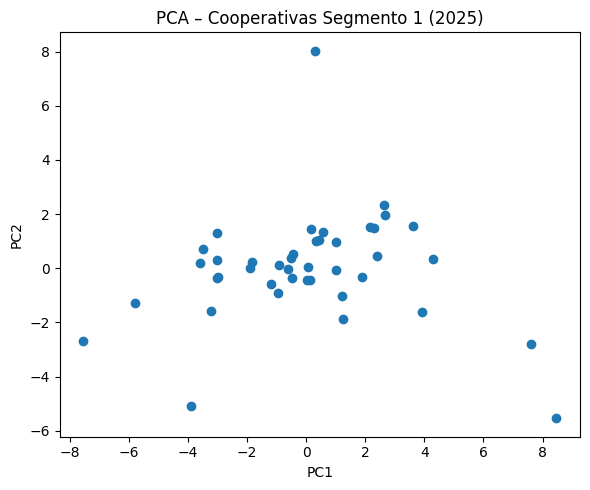


=== Silhouette scores ===
KMeans         : 0.11244693898352225
Agglomerative  : 0.13558892304372966
GaussianMixture: 0.11244693898352225

=== Ejemplo de tabla con clusters ===


,cluster_kmeans,cluster_agg,cluster_gmm
0,2,1,2
1,0,1,0
2,0,0,0
3,0,1,0
4,2,1,2


In [6]:
# ============================================
# 0) Imports
# ============================================
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# ============================================
# 1) Rutas
# ============================================
RUTA_CSV = "../data/processed/segmento1_csv/cooperativas_segmento1_completo_final.csv"

CARPETA_XLSM = "../data/processed/boletines_segmento1/csv_2025/2025-EEFF-MEN"
PATRON_XLSM_SEG1 = "*segmento 1*.xlsm"   # coincide con tu archivo
HEADER_ROW = 16  # <-- si al ver df_excel.head() no se ve bien, cambia este número

# ============================================
# 2) Función auxiliar: pasar texto a número
# ============================================
def to_numeric_safe(s):
    return (
        s.astype(str)
         .str.replace(".", "", regex=False)  # separador de miles
         .str.replace(",", ".", regex=False) # coma decimal
         .str.replace("%", "", regex=False)
         .str.strip()
    )

# ============================================
# 3) Intentar usar el CSV. Si no sirve, ir al XLSM.
# ============================================
print("Leyendo CSV original...")
df_csv = pd.read_csv(RUTA_CSV, dtype=str)
print("Shape CSV:", df_csv.shape)

# ¿Cuántas columnas numéricas tiene el CSV?
df_csv_num = pd.DataFrame()
for col in df_csv.columns:
    col_clean = pd.to_numeric(to_numeric_safe(df_csv[col]), errors="coerce")
    if col_clean.notna().sum() > 0:
        df_csv_num[col] = col_clean

if df_csv_num.shape[1] > 0:
    print("✅ El CSV ya tiene columnas numéricas utilizables.")
    df_source = df_csv.copy()
    df_num = df_csv_num.copy()
else:
    print("⚠ El CSV no tiene columnas numéricas útiles. Vamos a leer directo del XLSM...")

    # Buscar el XLSM de Segmento 1
    patron = os.path.join(CARPETA_XLSM, PATRON_XLSM_SEG1)
    archivos = glob.glob(patron)
    if not archivos:
        raise FileNotFoundError(f"No se encontró ningún XLSM con patrón {patron}")

    ruta_xlsm = archivos[0]
    print("Usando XLSM:", ruta_xlsm)

    # Leer la hoja de indicadores con un header estimado
    df_excel = pd.read_excel(
        ruta_xlsm,
        sheet_name="5. INDICADORES FINANCIEROS",
        header=HEADER_ROW
    )

    # Limpieza básica
    df_excel = df_excel.dropna(how="all").drop_duplicates()
    df_excel = df_excel.loc[:, ~df_excel.columns.astype(str).str.startswith("Unnamed")]
    df_excel.columns = (
        df_excel.columns.astype(str)
               .str.strip()
               .str.replace("\n", " ", regex=False)
               .str.replace("\r", " ", regex=False)
    )

    print("INFO df_excel:")
    print(df_excel.info())
    display(df_excel.head())

    # Construir df_num con las columnas numéricas
    df_num = pd.DataFrame()
    for col in df_excel.columns:
        serie_clean = pd.to_numeric(to_numeric_safe(df_excel[col]), errors="coerce")
        if serie_clean.notna().sum() > 0:
            df_num[col] = serie_clean

    if df_num.shape[1] == 0:
        raise ValueError(
            "No se pudieron extraer columnas numéricas del XLSM. "
            "Probablemente hay que ajustar HEADER_ROW a otra fila."
        )

    df_source = df_excel.copy()
    print("✅ df_num construido desde el XLSM. Shape:", df_num.shape)
    display(df_num.head())

# ============================================
# 4) Identificar columna de nombre de cooperativa (si existe)
# ============================================
col_id = None
for c in df_source.columns:
    cl = c.lower()
    if "coop" in cl or "entidad" in cl or "nombre" in cl or "denominac" in cl:
        col_id = c
        break

if col_id is not None:
    ids = df_source[col_id].astype(str)
else:
    ids = pd.Series(range(len(df_source)), name="id")

print("\nColumna identificadora:", col_id if col_id else "id genérico")

# ============================================
# 5) Preprocesamiento: imputación + escalado
# ============================================
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_imp = imputer.fit_transform(df_num)
X = scaler.fit_transform(X_imp)

print("X shape:", X.shape)

# ============================================
# 6) PCA para visualización
# ============================================
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA – Cooperativas Segmento 1 (2025)")
plt.tight_layout()
plt.show()

# ============================================
# 7) Clustering: KMeans, Agglomerative, GMM
# ============================================
k = 3  # puedes probar otros valores

kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels_km = kmeans.fit_predict(X)

agg = AgglomerativeClustering(n_clusters=k)
labels_agg = agg.fit_predict(X)

gmm = GaussianMixture(n_components=k, random_state=42)
labels_gmm = gmm.fit_predict(X)

print("\n=== Silhouette scores ===")
print("KMeans         :", silhouette_score(X, labels_km))
print("Agglomerative  :", silhouette_score(X, labels_agg))
print("GaussianMixture:", silhouette_score(X, labels_gmm))

# ============================================
# 8) DataFrame con clusters para análisis
# ============================================
df_clusters = df_source.copy()
df_clusters["cluster_kmeans"] = labels_km
df_clusters["cluster_agg"] = labels_agg
df_clusters["cluster_gmm"] = labels_gmm

print("\n=== Ejemplo de tabla con clusters ===")
cols_show = [col_id] if col_id else []
cols_show += ["cluster_kmeans", "cluster_agg", "cluster_gmm"]
display(df_clusters[cols_show].head())


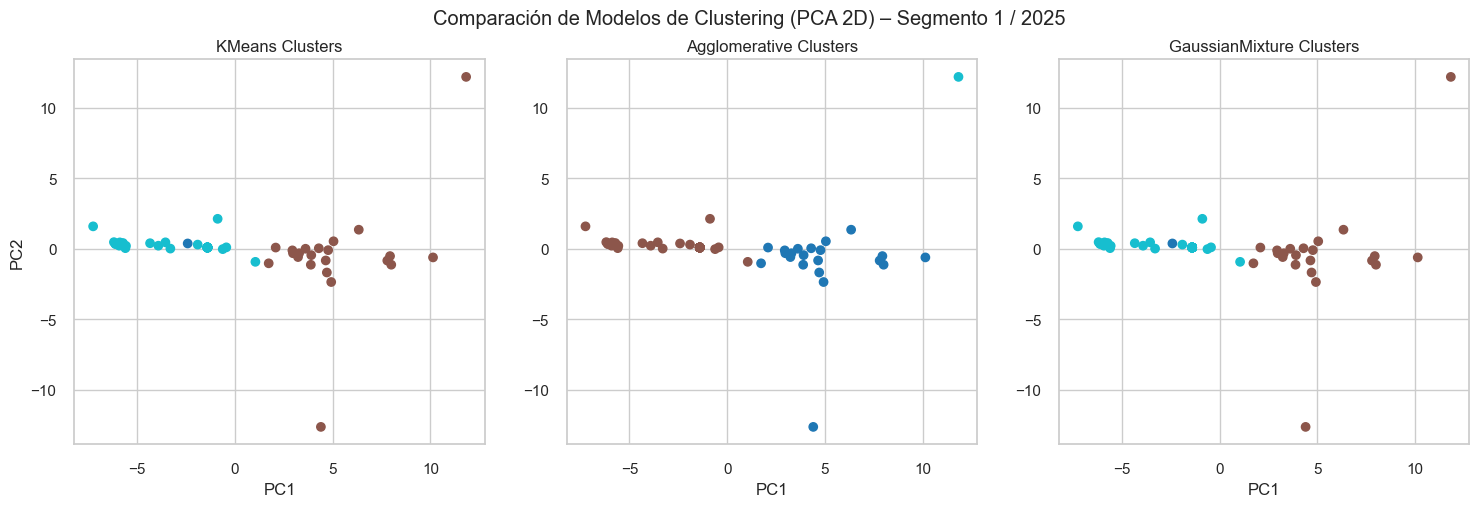

In [99]:
import seaborn as sns
sns.set(style="whitegrid", palette="Paired")

fig, ax = plt.subplots(1,3,figsize=(18,5))

ax[0].scatter(X_pca[:,0], X_pca[:,1], c=labels_km, cmap="tab10") 
ax[0].set_title("KMeans Clusters")
ax[0].set_xlabel("PC1"); ax[0].set_ylabel("PC2")

ax[1].scatter(X_pca[:,0], X_pca[:,1], c=labels_agg, cmap="tab10") 
ax[1].set_title("Agglomerative Clusters")
ax[1].set_xlabel("PC1")

ax[2].scatter(X_pca[:,0], X_pca[:,1], c=labels_gmm, cmap="tab10") 
ax[2].set_title("GaussianMixture Clusters")
ax[2].set_xlabel("PC1")

plt.suptitle("Comparación de Modelos de Clustering (PCA 2D) – Segmento 1 / 2025")
plt.show()
